# 1. KMeans 
## 1.1 KMeans with 9 groups

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [31]:
np.random.seed(42)

In [32]:
import os
os.chdir('/Users/Rachel/Desktop/AtomicIOT/Rachel/Sagemaker/Data')
os.getcwd()

train1 = pd.read_csv('AUGandOCT.csv')
train2 = pd.read_csv('Cleaned_Data_Orig(17_11-18_06)/Cleaned_Data_Orig(17_11-18_06).csv')
train_all = train1.append(train2, ignore_index = True)

In [33]:
train = train_all.sample(frac=0.7)
test = train_all.loc[~train_all.index.isin(train.index)]

In [34]:
def encode(x):
    le=LabelEncoder()
    le.fit(x)
    x=le.transform(x)
    return x
def hamdist(str1, str2):        
        diffs = 0
        for ch1, ch2 in zip(str1, str2):
                if ch1 != ch2:
                        diffs += 1
        return diffs

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [36]:
train[['uri_num','query_num','CN','OU','O']] = \
train[['uri_num','query_num','CN','OU','O']].fillna(0)
train[['query_text','SAX_resp_h']] = \
train[['query_text','SAX_resp_h']].fillna('DNE')
train['SAX_resp_ham']=train.SAX_resp_h.apply(lambda x: hamdist(x,'bbbbbbbbbbbbbbbbbbbbbbbb'))
train = train.drop(['mac','ts'],1)[train.IOT == 'Y']
train[['query_text','SAX_resp_h']] = \
train[['query_text','SAX_resp_h']].apply(encode)
Feature = ['id_resp_h_num','proto_num','conn_state_num','history_num',
           'uri_num','query_num','up_down','O','OU','IOT','Device','query_text','SAX_resp_h','SAX_resp_ham']
train = train[Feature]
train = train.drop(['IOT'],1)
train.head()

,id_resp_h_num,proto_num,conn_state_num,history_num,uri_num,query_num,up_down,O,OU,Device,query_text,SAX_resp_h,SAX_resp_ham
2166,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,Sonos,918,4,24
3422,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,Kindle,918,4,24
1905,9,1,2,5,4.0,4.0,0.124837,4.0,4.0,Sonos,893,207,24
3307,7,1,2,8,1.0,4.0,0.286478,1.0,2.0,Kindle,390,259,24
4845,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,Nest,918,4,24


In [37]:
train[['Device']]= train[['Device']].apply(encode)
train.head()

,id_resp_h_num,proto_num,conn_state_num,history_num,uri_num,query_num,up_down,O,OU,Device,query_text,SAX_resp_h,SAX_resp_ham
2166,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,7,918,4,24
3422,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,3,918,4,24
1905,9,1,2,5,4.0,4.0,0.124837,4.0,4.0,7,893,207,24
3307,7,1,2,8,1.0,4.0,0.286478,1.0,2.0,3,390,259,24
4845,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,4,918,4,24


In [38]:
train = (train - train.mean()) / (train.max() - train.min())

In [39]:
target = 'Device'
predictors = [x for x in train.columns if x not in [target]]
X = train[predictors]
y = train[target]
n_samples, n_features = X.shape
n_digits =9
labels = y

In [40]:
sample_size = 300

In [41]:
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 9, 	 n_samples 2879, 	 n_features 12


In [44]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=train[predictors])

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=train[predictors])



k-means++	0.24s	95	0.291	0.281	0.286	0.144	0.276	0.726
random   	0.07s	107	0.289	0.284	0.286	0.146	0.280	0.711


In [47]:
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(train)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=train)
print(82 * '_')

PCA-based	0.01s	385	0.434	0.424	0.429	0.239	0.421	0.427
__________________________________________________________________________________


In [48]:
reduced_data = PCA(n_components=2).fit_transform(train)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

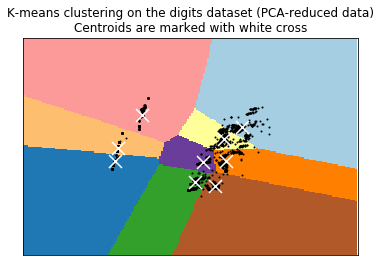

In [49]:
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [51]:
Z

array([[1, 1, 1, ..., 8, 8, 8],
       [1, 1, 1, ..., 8, 8, 8],
       [1, 1, 1, ..., 8, 8, 8],
       ..., 
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]], dtype=int32)

In [52]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
Z1 = kmeans.predict()